In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.covariance
import sklearn.cluster
import datetime
import fastdtw

In [3]:
met = pd.read_hdf('../../input/df/met/usa_ds3505.h5').loc[724050]

In [4]:
obs = pd.read_hdf('../../input/df/obs/cherry_dc.h5').loc['DC']

In [5]:
#years = list(range(1940, 2010))
years = list(set(range(1940, 2010)) - set([1946, 1970, 1971, 1972, 1973]))

In [6]:
def timeseries(year, length=5000, s=met.tavg):
    t = datetime.date(year-1, 10, 1)
    return np.array(s.loc[t:][:length])

In [7]:
def timeseriess(years, length=5000, s=met.tavg):
    return np.array([timeseries(y, length, s) for y in years])

In [8]:
def timeframe(year, length=5000, s=met.tavg, to_dict=False):
    t = datetime.date(year-1, 10, 1)
    hows = ['mean', 'min', 'max']
    a = np.array([s.loc[t:][:length].resample('D', how=h) for h in hows])
    if to_dict:
        return dict(zip(hows, a))
    else:
        return a.T

In [9]:
def timeframes(years, length=5000, s=met.tavg):
    return np.array([timeframe(y, length, s).flatten() for y in years])

In [10]:
def affinity_matrix_hourly(years, length=5000, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    for (i, yi) in enumerate(years):
        ai = timeseries(yi, length, s)
        for (j, yj) in enumerate(years):
            if i == j:
                M[i, j] = 1
            else:
                aj = timeseries(yj, length, s)
                d = fastdtw.fastdtw(ai, aj, radius=1)[0]
                M[i, j] = M[j, i] = 1/d
    return M

In [11]:
def affinity_matrix_daily(years, length=5000, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    for (i, yi) in enumerate(years):
        ai = timeframe(yi, length, s)
        for (j, yj) in enumerate(years):
            if i == j:
                M[i, j] = 1
            else:
                aj = timeframe(yj, length, s)
                d = fastdtw.fastdtw(ai, aj, radius=1, dist=lambda x, y: sum((x - y)**2)**0.5)[0]
                M[i, j] = M[j, i] = 1/d
    return M

In [12]:
def affinity_matrix_daily_mean(years, length=5000, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    for (i, yi) in enumerate(years):
        ai = timeframe(yi, length, s, to_dict=True)['mean']
        for (j, yj) in enumerate(years):
            if i == j:
                M[i, j] = 1
            else:
                aj = timeframe(yj, length, s, to_dict=True)['mean']
                d = fastdtw.fastdtw(ai, aj, radius=1)[0]
                M[i, j] = M[j, i] = 1/d
    return M

In [13]:
def affinity_matrix_daily_diff(years, length=5000, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    am = np.array([timeframe(y, length, s, to_dict=True)['mean'] for y in years]).mean(axis=0)
    for (i, yi) in enumerate(years):
        ai = timeframe(yi, length, s, to_dict=True)['mean'] - am
        for (j, yj) in enumerate(years):
            if i == j:
                M[i, j] = 1
            else:
                aj = timeframe(yj, length, s, to_dict=True)['mean'] - am
                d = fastdtw.fastdtw(ai, aj, radius=1)[0]
                M[i, j] = M[j, i] = 1/d
    return M

In [14]:
def affinity_matrix_daily_cumulative_residual(years, length=5000, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    am = np.array([timeframe(y, length, s, to_dict=True)['mean'] for y in years]).mean(axis=0)
    def a(y):
        ad = timeframe(y, length, s, to_dict=True)['mean'] - am
        return np.array([ad.clip(min=0).cumsum(), ad.clip(max=0).cumsum()]).T
    for (i, yi) in enumerate(years):
        ai = a(yi)
        for (j, yj) in enumerate(years):
            if i == j:
                M[i, j] = 1
            else:
                aj = a(yj)
                d = fastdtw.fastdtw(ai, aj, radius=1, dist=lambda x, y: sum((x - y)**2)**0.5)[0]
                M[i, j] = M[j, i] = 1/d
    return M

In [15]:
def affinity_matrix_daily_cumulative_diff(years, length=5000, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    def a(y):
        tf = timeframe(y, length, s, to_dict=True)['mean']
        ad = tf[:-1] - tf[1:]
        return np.array([ad.clip(min=0).cumsum(), ad.clip(max=0).cumsum()]).T
    for (i, yi) in enumerate(years):
        ai = a(yi)
        for (j, yj) in enumerate(years):
            if i == j:
                M[i, j] = 1
            else:
                aj = a(yj)
                d = fastdtw.fastdtw(ai, aj, radius=1, dist=lambda x, y: sum((x - y)**2)**0.5)[0]
                M[i, j] = M[j, i] = 1/d
    return M

In [16]:
def affinity_matrix_hourly_cumulative_residual(years, length=5000, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    am = np.array([timeseries(y, length, s) for y in years]).mean(axis=0)
    def a(y):
        ad = timeseries(y, length, s) - am
        return np.array([ad.clip(min=0).cumsum(), ad.clip(max=0).cumsum()]).T
    for (i, yi) in enumerate(years):
        ai = a(yi)
        for (j, yj) in enumerate(years):
            if i == j:
                M[i, j] = 1
            else:
                aj = a(yj)
                d = fastdtw.fastdtw(ai, aj, radius=1, dist=lambda x, y: sum((x - y)**2)**0.5)[0]
                M[i, j] = M[j, i] = 1/d
    return M

In [17]:
def covariance_matrix(years, length=5000, s=met.tavg):
    X = np.array([timeseries(y, length, s) for y in years])
    cov = sklearn.covariance.GraphLassoCV()
    cov.fit(X.T)
    return cov.covariance_

In [18]:
def correlation_matrix(years, length=5000, s=met.tavg):
    n = len(years)
    M = np.zeros(n*n).reshape(n, n)
    for (i, yi) in enumerate(years):
        ai = pd.Series(timeseries(yi, length, s))
        for (j, yj) in enumerate(years):
            aj = pd.Series(timeseries(yj, length, s))
            M[i, j] = M[j, i] = ai.corr(aj)
    return M

In [19]:
def timefeature(year, length=5000, s=met.tavg, to_dict=False):
    t = datetime.date(year-1, 10, 1)
    df = s.loc[t:][:length]
    def feature(h):
        v = df.resample('M', h).tolist()
        if to_dict:
            k = ['t{}{}'.format(h, i) for i in range(len(v))]
            return dict(zip(k, v))
        else:
            return v
    fs = [feature(h) for h in {'mean', 'min', 'max'}]
    if to_dict:
        d = {}
        [d.update(f) for f in fs]
        return d
    else:
        return sum(fs, [])

In [20]:
def affinity_matrix_feature(years, length=5000, s=met.tavg):
    X = np.array([timefeature(y) for y in years])
    return sklearn.metrics.pairwise_distances(X)

In [21]:
import scipy.signal

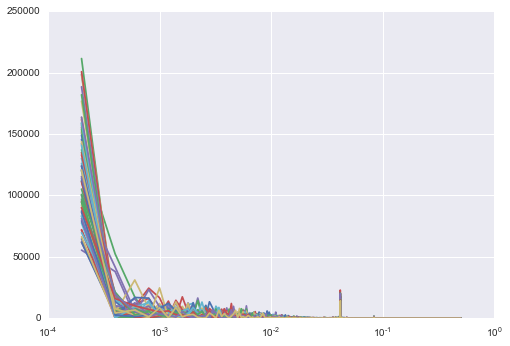

In [22]:
for y in years:
    plt.semilogx(*scipy.signal.periodogram(timeseries(y)))

In [23]:
#M = affinity_matrix_daily(years)
#M = affinity_matrix_hourly(years)
M = correlation_matrix(years)
af = sklearn.cluster.AffinityPropagation(affinity='precomputed').fit(M)

In [24]:
groups = np.unique(af.labels_)
groups

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [25]:
mask = np.zeros_like(M, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

In [26]:
np.ma.array(M, mask=mask).max()

0.71511374179813947

In [27]:
M.min()

0.32242378704776636

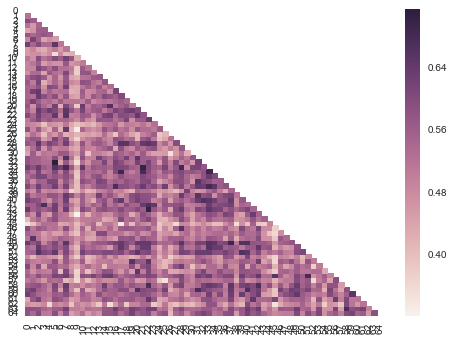

In [28]:
sns.set(style='white')
sns.heatmap(M, mask=mask, vmax=np.ma.array(M, mask=mask).max(), vmin=M.min())

In [29]:
DM = 1/M
np.fill_diagonal(DM, 0)
D = scipy.spatial.distance.squareform(DM)

{'color_list': ['b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b'],
 'dcoord': [[0.0, 1.613201320751791, 1.613201320751791, 0.0],
  [0.0, 1.5311837790994287, 1.5311837790994287, 0.0],
  [0.0, 1.5192479646897485, 1.5192479646897485, 0.0],
  [0.0, 1.4820651346905913, 1.4820651346905913, 0.0],
  [0.0, 1.4196592621266277, 1.4196592621266277, 0.0],
  [0.0, 1.4850051191206839, 1.4850051191206839, 1.4196592621266277],
  [0.0, 1.4859363701789614, 1.4859363701789614, 1.4850051191206839],
  [1.4820651346905913,
   1.4969944059132114,
   1.4969944059132114,
   1.4859363701789614],
  [0.0, 1.3983789452647346, 

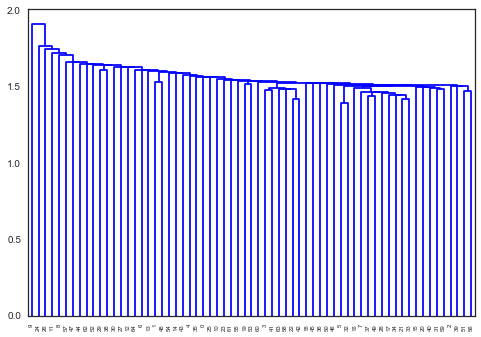

In [30]:
Z = scipy.cluster.hierarchy.linkage(D)
scipy.cluster.hierarchy.dendrogram(Z)

In [31]:
def plot_group_hourly(af, years, group):
    for i, y in enumerate(years):
        if af.labels_[i] == group:
            print(y)
            pd.Series(timeseries(y)).plot(figsize=(4,3), ylim=(-25, 35))

In [32]:
def plot_group_daily(af, years, group):
    for i, y in enumerate(years):
        if af.labels_[i] == group:
            print(y)
            pd.DataFrame(timeframe(y, to_dict=True)).plot(figsize=(4,3), ylim=(-25, 35))

In [33]:
def plot_group_daily_cumulative_residual(af, years, group, length=5000, s=met.tavg):
    am = np.array([timeframe(y, length, s, to_dict=True)['mean'] for y in years]).mean(axis=0)
    def a(y):
        ad = timeframe(y, length, s, to_dict=True)['mean'] - am
        return np.array([ad.clip(min=0).cumsum(), ad.clip(max=0).cumsum()]).T
    for i, y in enumerate(years):
        if af.labels_[i] == group:
            print(y)
            ai = a(y).T
            plt.figure(figsize=(10,1))
            plt.subplot(1, 2, 1)
            pd.Series(ai[0]).plot(ylim=(0,500))
            plt.subplot(1, 2, 2)
            pd.Series(ai[1]).plot(ylim=(-500,0))

In [34]:
def plot_group_daily_cumulative_residual(af, years, group, length=5000, s=met.tavg):
    am = np.array([timeframe(y, length, s, to_dict=True)['mean'] for y in years]).mean(axis=0)
    def a(y):
        ad = timeframe(y, length, s, to_dict=True)['mean'] - am
        return np.array([ad.clip(min=0).cumsum(), ad.clip(max=0).cumsum()]).T    
    plt.figure(figsize=(10,1))
    plt.subplot(1, 2, 1)
    for i, y in enumerate(years):
        if af.labels_[i] == group:
            ai = a(y).T
            pd.Series(ai[0]).plot(ylim=(0,500))
    plt.subplot(1, 2, 2)
    for i, y in enumerate(years):
        if af.labels_[i] == group:
            pd.Series(ai[1]).plot(ylim=(-500,0))

In [60]:
M

array([[ 1.        ,  0.52191413,  0.59677404, ...,  0.46974913,
         0.58654641,  0.58455249],
       [ 0.52191413,  1.        ,  0.56398793, ...,  0.45559734,
         0.58671386,  0.54078576],
       [ 0.59677404,  0.56398793,  1.        , ...,  0.46198655,
         0.58125785,  0.59921484],
       ..., 
       [ 0.46974913,  0.45559734,  0.46198655, ...,  1.        ,
         0.49622081,  0.45621323],
       [ 0.58654641,  0.58671386,  0.58125785, ...,  0.49622081,
         1.        ,  0.58909443],
       [ 0.58455249,  0.54078576,  0.59921484, ...,  0.45621323,
         0.58909443,  1.        ]])

1941
1947
1960
1993


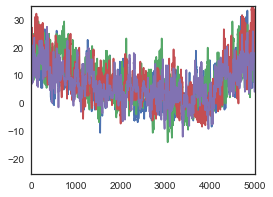

In [59]:
plt.figure()
plot_group_hourly(af, years, 0)

1950


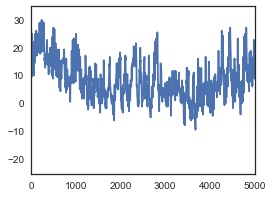

In [36]:
plt.figure()
plot_group_hourly(af, years, 1)

In [37]:
#plot_group_daily(af, years, 0)

In [38]:
npm = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=5, n_components=2)

In [39]:
embedding = npm.fit_transform(timeseriess(years)).T
#embedding = npm.fit_transform(timeframes(years)).T

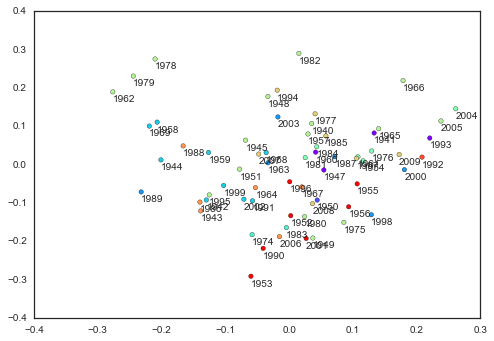

In [40]:
plt.scatter(embedding[0], embedding[1], c=af.labels_, cmap=plt.cm.rainbow)
for (i, (x, y)) in enumerate(zip(*embedding)):
    plt.text(x, y - 0.025, '{}'.format(years[i]), size='small')

In [41]:
df = pd.DataFrame(years, af.labels_)

In [42]:
#df.reset_index().sort_values(['index', 0]).set_index(['index'])

In [43]:
def extract_years(af, years, group):
    df = pd.DataFrame(years, af.labels_)
    return df[df.index == group][0].tolist()

In [44]:
extract_years(af, years, 0)

[1941, 1947, 1960, 1993]

In [45]:
{g: extract_years(af, years, g) for g in groups}

{0: [1941, 1947, 1960, 1993],
 1: [1950],
 2: [1963, 1987, 1989, 1998, 2000, 2003],
 3: [1942, 1944, 1958, 1959, 1968, 1969, 1991, 1999, 2002],
 4: [1974, 1983],
 5: [1954, 1961, 1976, 1981, 1984, 2004],
 6: [1940,
  1945,
  1948,
  1949,
  1951,
  1957,
  1962,
  1965,
  1966,
  1975,
  1978,
  1979,
  1980,
  1982,
  1995,
  2005],
 7: [1977, 1985, 1994, 1997, 2007, 2008, 2009],
 8: [1943, 1964, 1967, 1986, 1988, 2006],
 9: [1992],
 10: [1952, 1953, 1955, 1956, 1990, 1996, 2001]}

Group 8 includes the years of top 6 (1996), 7 (1983), 8 (2009), and 9 (2003) snowstorms in Washington, D.C.
Reference: http://www.wusa9.com/story/weather/2016/01/21/these-top-10-snowfalls-dc-history/79120848/

In [46]:
def extract_stat(af, years, group):
    v = np.array([timeseries(y) for y in extract_years(af, years, group)])
    return {
        'mean': v.mean(axis=1).mean(),
        'min': v.min(axis=1).min(),
        'max': v.max(axis=1).max(),
    }

In [47]:
{g: extract_stat(af, years, g) for g in groups}

{0: {'max': 34.600000000000001,
  'mean': 7.4808689285714287,
  'min': -13.699999999999999},
 1: {'max': 30.199999999999999,
  'mean': 8.5967399999999987,
  'min': -9.1999999999999993},
 2: {'max': 32.399999999999999, 'mean': 7.6311741029223574, 'min': -15.9},
 3: {'max': 35.600000000000001,
  'mean': 8.0798897325304111,
  'min': -15.300000000000001},
 4: {'max': 30.0, 'mean': 9.1212194983277595, 'min': -8.1999999999999993},
 5: {'max': 35.0, 'mean': 8.2026861102616238, 'min': -17.100000000000001},
 6: {'max': 34.100000000000001, 'mean': 7.7400555416837653, 'min': -20.5},
 7: {'max': 33.299999999999997, 'mean': 7.8936268943313141, 'min': -20.0},
 8: {'max': 31.300000000000001,
  'mean': 7.7224085775591051,
  'min': -16.699999999999999},
 9: {'max': 29.399999999999999,
  'mean': 8.1564999999999994,
  'min': -9.9000000000000004},
 10: {'max': 34.100000000000001, 'mean': 7.6152226513768326, 'min': -15.0}}

In [48]:
def affinity_daily(af, years, year, group, length=5000, s=met.tavg):
    years_group = extract_years(af, years, group)
    n = len(years_group)
    ai = timeframe(year, length, s)
    M = np.zeros(n)
    for (j, yj) in enumerate(years_group):
        aj = timeframe(yj, length, s)
        d = fastdtw.fastdtw(ai, aj, dist=lambda x, y: sum((x - y)**2)**0.5)[0]
        M[j] = d
    return M

In [49]:
def predict_group_daily(af, years, year, length=5000, s=met.tavg):
    r = np.array([affinity_daily(af, years, year, g).mean() for g in groups])
    ir = 1/r
    return (r.argmin(), ir/ir.sum())

In [50]:
predict_group_daily(af, years, 2015)

(0, array([ 0.10016283,  0.05328284,  0.09808537,  0.0939418 ,  0.09577451,
         0.08596501,  0.09278576,  0.09933974,  0.09906459,  0.09279303,
         0.08880452]))

In [51]:
predict_group_daily(af, years, 2014)

(9, array([ 0.08124851,  0.08903687,  0.08748888,  0.09182357,  0.09158967,
         0.09225803,  0.08713601,  0.08254082,  0.09932682,  0.1002153 ,
         0.09733552]))

In [52]:
predict_group_daily(af, years, 2013)

(9, array([ 0.09128967,  0.09807774,  0.08067381,  0.08602773,  0.09499813,
         0.08103377,  0.08492682,  0.08880231,  0.08712342,  0.11785696,
         0.08918963]))

In [53]:
predict_group_daily(af, years, 2012)

(9, array([ 0.07507798,  0.09192207,  0.09467332,  0.09439219,  0.09325387,
         0.10085404,  0.08194157,  0.08236168,  0.09804218,  0.1011266 ,
         0.08635451]))

In [54]:
predict_group_daily(af, years, 2011)

(9, array([ 0.0806903 ,  0.08274445,  0.10509513,  0.09834576,  0.0869088 ,
         0.08829893,  0.0833505 ,  0.08096405,  0.08836028,  0.1136095 ,
         0.09163229]))

In [55]:
predict_group_daily(af, years, 2010)

(8, array([ 0.09633882,  0.08099595,  0.08741795,  0.08894395,  0.09528155,
         0.07814839,  0.09659617,  0.09076676,  0.10330476,  0.09580261,
         0.08640311]))

In [56]:
[affinity_daily(af, years, 2011, g).mean() for g in groups]

[2184.115246816315,
 2129.8939504746204,
 1676.9273886744968,
 1792.0133252464821,
 2027.8372199132268,
 1995.9120094300924,
 2114.4071842523181,
 2176.7302269437319,
 1994.5262334649408,
 1551.2514873354764,
 1923.3057179981672]